## 🤖 **Parte 2 — Modelado y Evaluación**

### 🎯 **Objetivo**
Entrenar un modelo de regresión para predecir la variable `price_usd`.

### 🔹 **Lineamientos**
*   **Modelo:** Pueden elegir el que consideren más adecuado (ej. **Linear Regression, RandomForest, XGBoost, LightGBM**, etc.).
*   **División de datos:** Separar los datos en conjuntos de **entrenamiento (train) y prueba (test)**. El porcentaje de división es libre, pero debe estar justificado.
*   **Proceso iterativo:** Para llegar al modelo final, se deben construir varios modelos intermedios. Es crucial explicar las conclusiones parciales obtenidas en cada iteración y por qué se eligió el modelo final.

### 🔹 **Métricas de Evaluación**
Utilizar al menos una de las siguientes métricas:
*   **RMSE** (Root Mean Squared Error)
*   **MAE** (Mean Absolute Error)
*   **R²:** Pueden utilizarlo como guía para evaluar el ajuste del modelo.

> 💡 **Extra:** Comparar RMSE y MAE puede ayudar a entender cómo los outliers están afectando el rendimiento del modelo.

### 🔹 **Entregables de esta parte**
*   **Notebook de modelado:** Incluir el proceso de entrenamiento, las métricas obtenidas y un breve análisis de los resultados.
*   **Insights del modelo:** Presentar al menos **dos insights** clave que se hayan descubierto durante el proceso de creación del modelo.
*   **Justificación de variables:** Explicar qué variables se incluyeron en el modelo final y cuáles se descartaron, fundamentando la decisión.
*   **Exportación del modelo:** Guardar el modelo entrenado (`model.pkl`) y, si aplica, el preprocesador (`preprocess.pkl` o el pipeline completo).

In [4]:
""" Cargamos las librerias"""
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
import warnings 
warnings.filterwarnings("ignore")

In [5]:
"""Cargar el dataset original de Properati"""
df_modelo= pd.read_csv("../01_EDA/data/processed.csv")

In [3]:
""" Variables predictoras y objetivo"""
X = df_modelo.drop(columns=['price'])
y = df_modelo['price']


# Separación de entrenamiento y prueba

In [4]:
"""Separar columnas categóricas y numéricas"""
num_features = ['superficie', 'rooms', 'bedrooms', 'bathrooms', 'lat', 'lon']
cat_features = ['property_type', 'state_name', 'place_name']

""" División en train y test
 80% entrenamiento - 20% prueba (justificación: tamaño suficiente para validar sin sobreajustar)"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo final

In [5]:
""" ==========================================
         Construcción del pipeline
   ==========================================

 Escalado numérico y codificación categórica"""
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

""" Modelo base: Random Forest (robusto ante no linealidades y outliers)"""
model = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    max_depth=20
)

""" Crear pipeline completo"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

""" Entrenamiento """
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['superficie', 'rooms',
                                                   'bedrooms', 'bathrooms',
                                                   'lat', 'lon']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['property_type',
                                                   'state_name',
                                                   'place_name'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=150,
                                       n_jobs=-1, random_state=42))])

In [6]:
"""==========================================
                3. Evaluación
   ==========================================

 Predicciones"""
y_pred = pipeline.predict(X_test)

""" Métricas """
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.3f}")


MAE: 41,327.11
RMSE: 88,747.51
R²: 0.867


***Conclusiones breves del modelo***

El modelo tiene un error promedio de 41,327 unidades entre lo predicho y lo real, lo que indica una buena precisión general. El error cuadrático medio es de 88,748, lo que sugiere que, aunque existen algunos casos con errores grandes, el desempeño global sigue siendo sólido. El coeficiente de determinación R² de 0.867 muestra que el modelo explica el 86.7% de la variabilidad de los datos, lo que significa que tiene una capacidad predictiva alta y representa bien las relaciones entre las variables

# Iteraciones de distintos modelos para obtener el final 

In [ ]:
""" Iteraciones """
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

""" a) Modelo lineal """ 
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_lr.fit(X_train, y_train)

""" b) Modelo XGBoost """ 
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        random_state=42
    ))
])
pipe_xgb.fit(X_train, y_train)

""" c) Modelo LightGBM """ 
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])
pipe_lgb.fit(X_train, y_train)

""" Comparar métricas """ 
def evaluar_modelo(nombre, modelo):
    pred = modelo.predict(X_test)
    print(f"\n🔹 {nombre}")
    print(f"MAE: {mean_absolute_error(y_test, pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred)):,.2f}")
    print(f"R²: {r2_score(y_test, pred):.3f}")

evaluar_modelo("Random Forest", pipeline)
evaluar_modelo("Linear Regression", pipe_lr)
evaluar_modelo("XGBoost", pipe_xgb)
evaluar_modelo("LightGBM", pipe_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 146450, number of used features: 108
[LightGBM] [Info] Start training from score 249458.196402

🔹 Random Forest
MAE: 41,327.11
RMSE: 88,747.51
R²: 0.867

🔹 Linear Regression
MAE: 105,346.88
RMSE: 173,556.62
R²: 0.490

🔹 XGBoost
MAE: 56,003.47
RMSE: 103,379.12
R²: 0.819

🔹 LightGBM
MAE: 56,362.58
RMSE: 103,573.32
R²: 0.818


***Conclusiones parcial de las iteraciones:***
El modelo Random Forest fue el que mejor funcionó en general. Logró los errores más bajos (MAE de 41,327 y RMSE de 88,748) y un R² de 0.867, lo que significa que explica casi el 87% de la variación de los datos. En otras palabras, sus predicciones son bastante precisas y consistentes. Este modelo logra un buen equilibrio entre precisión y capacidad de generalizar sin necesidad de muchos ajustes.

La regresión lineal, por otro lado, tuvo el rendimiento más débil. Con un R² de 0.49 y errores mucho más altos, deja claro que no logra capturar bien las relaciones más complejas o no lineales entre las variables. Aun así, sigue siendo útil cuando se quiere interpretar fácilmente el peso de cada variable, aunque no sea el más preciso para este tipo de problema.

El modelo XGBoost mejoró bastante los resultados frente al lineal. Con un R² de 0.819, muestra que entiende mejor las interacciones entre las variables y logra predicciones más cercanas a la realidad. Sin embargo, sigue quedando un poco por detrás de Random Forest, y necesita un ajuste más fino de sus hiperparámetros para alcanzar su máximo potencial.

Por último, LightGBM ofreció resultados casi idénticos a los de XGBoost (R² de 0.818). Es igualmente potente y eficiente, pero en este caso tampoco logró superar el desempeño de Random Forest.

En resumen, Random Forest fue el modelo elegido porque ofrece el mejor balance entre exactitud, estabilidad y facilidad de uso. No solo predice con mayor precisión, sino que también lo hace sin complicaciones excesivas, lo que lo convierte en la opción más confiable para este conjunto de datos.

## Insights del modelo

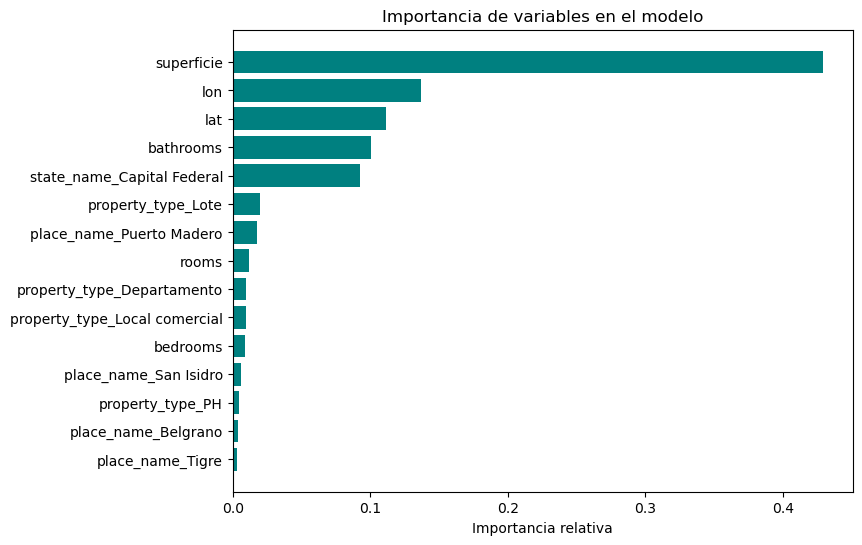

In [9]:
# ==========================================
# Importancia de variables
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las columnas transformadas
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, cat_names])

# Importancias del modelo RandomForest
importances = pipeline.named_steps['model'].feature_importances_

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]
top_features = all_features[indices][:15]
top_importances = importances[indices][:15]

# Visualizar las más importantes
plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], top_importances[::-1], color='teal')
plt.title("Importancia de variables en el modelo")
plt.xlabel("Importancia relativa")
plt.show()


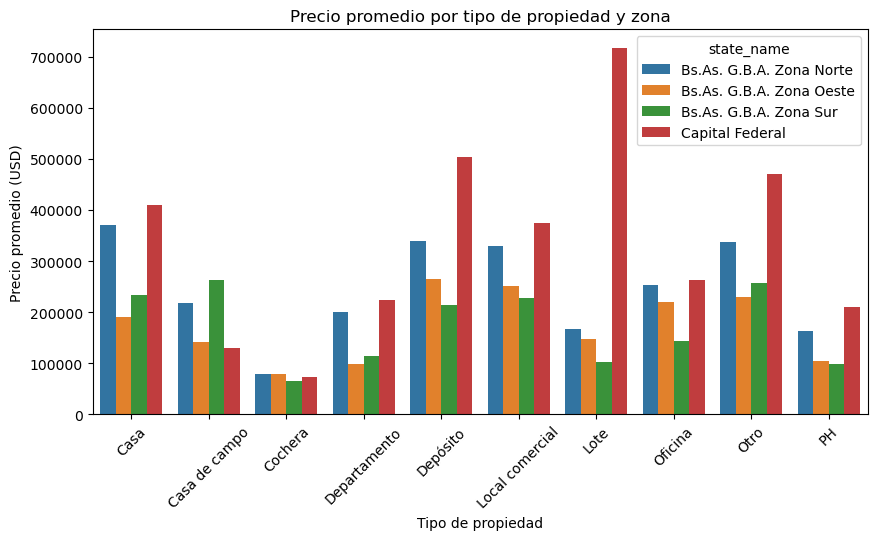

In [15]:
# Precio promedio por tipo y zona
promedios = df_modelo.groupby(['state_name', 'property_type'])['price'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=promedios, x='property_type', y='price', hue='state_name')
plt.title("Precio promedio por tipo de propiedad y zona")
plt.ylabel("Precio promedio (USD)")
plt.xlabel("Tipo de propiedad")
plt.xticks(rotation=45)
plt.show()


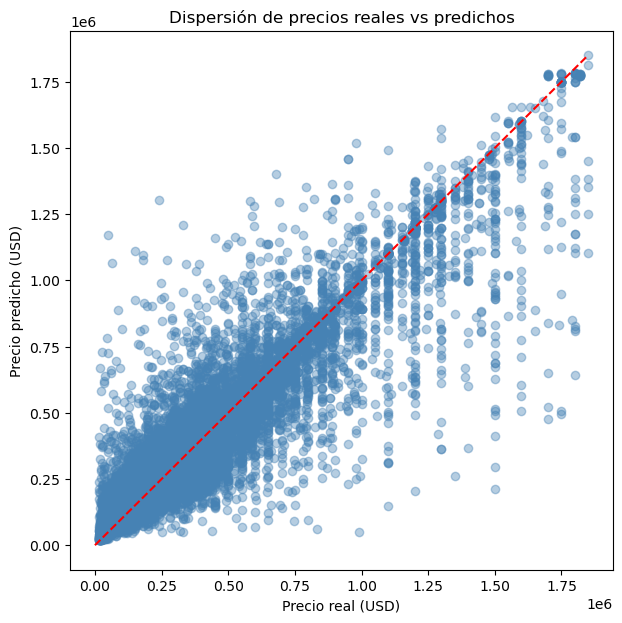

In [14]:
# ==========================================
# Comparación de valores reales vs predichos
# ==========================================
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.4, color='steelblue')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.title("Dispersión de precios reales vs predichos")
plt.show()


***Insights del modelo***

1. ***Superficie y ubicación como principales impulsores del precio***:
El análisis de importancia de variables confirma que la superficie es el factor más determinante del precio, seguida por la ubicación geográfica (latitud y longitud).
Estas tres variables explican la mayor parte de la variabilidad del precio, lo que valida su inclusión como predictores clave dentro del modelo de regresión.

2. ***Influencia del tipo de propiedad y la zona***:
Se observa que el tipo de propiedad (departamento, casa, lote, PH, etc.) y la zona geográfica (CABA o GBA) también tienen peso relevante en la predicción.
Esto refleja las diferencias estructurales, urbanas y socioeconómicas del mercado inmobiliario argentino, donde los valores varían significativamente entre áreas metropolitanas y residenciales.

3. ***Mayor error en propiedades de lujo (outliers)***:
Al comparar los precios reales y predichos, se observa que el modelo tiende a subestimar o sobrestimar los valores más altos. Esto indica que las propiedades de lujo, menos representadas en el conjunto de datos, generan los errores más grandes, lo que se evidencia en la diferencia entre RMSE y MAE.

# Justificación de variables

***Variables incluidas en el modelo***

1. ***price:***
Variable objetivo del modelo. Representa el valor de venta en dólares de cada propiedad y es la métrica que se busca predecir.

2. ***superficie:***
Es el principal determinante del precio, ya que el valor de un inmueble está altamente correlacionado con su tamaño. Propiedades con mayor superficie tienden a tener precios más altos. Además, combina información de surface_total y surface_covered, aumentando la completitud de los datos.

3. ***rooms, bedrooms, bathrooms:***
Estas variables describen la funcionalidad y el confort de una propiedad. El número de ambientes, dormitorios y baños influye directamente en su valor percibido. Se mantienen como indicadores estructurales complementarios a la superficie.

4. ***property_type:***
Diferencia entre casas, departamentos, PH, lotes, etc. Es una variable fundamental, ya que el tipo de construcción afecta significativamente el precio por m² y el segmento de mercado al que pertenece cada propiedad.

5. ***place_name, state_name, lat, lon:***
Conjunto de variables que definen la ubicación geográfica, el factor más influyente del mercado inmobiliario.

* state_name distingue entre CABA y GBA.

* place_name permite capturar variaciones por barrio o localidad.

* lat y lon ofrecen precisión espacial y la posibilidad de calcular distancias a zonas de interés.

En conjunto, estas variables representan el componente geográfico que más incide en el valor de una propiedad.

***Variables descartadas***
1. ***title y description:***
Se eliminaron por ser texto libre. Si bien podrían aportar información semántica, requerirían un procesamiento adicional (NLP) que excede el alcance de este modelo.

2. ***price_period:***
Tiene muchos valores nulos y aplica principalmente a propiedades en alquiler. No aporta información útil en un modelo centrado en precios de venta.

3. ***l4, l5, l6:***
Altamente incompletas (>60% de valores faltantes). Representan subniveles geográficos redundantes o con baja consistencia.

4. ***Variables derivadas de fechas (start_date, end_date, created_on):***
No se incluyen porque la fecha de publicación no influye directamente en el valor de la propiedad, sino en su disponibilidad.

# Guardar el modelo en pickle

In [18]:
""" Guardar modelo y preprocesador"""
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['model']

joblib.dump(model, 'modelo/model.pkl')
joblib.dump(preprocessor, 'modelo/preprocess.pkl')
print("✅ Modelo exportado como 'model.pkl'")
print("✅ Modelo exportado como 'preprocess.pkl'")

✅ Modelo exportado como 'model.pkl'
✅ Modelo exportado como 'preprocess.pkl'
